# Flowers Recognition using Image Classification

The dataset is taken from Kaggle (https://www.kaggle.com/alxmamaev/flowers-recognition), consists of 4242 images showcasing various flowers. The collection is assembled from Flickr, Google Images, and Yandex Images. With five distinct classes—chamomile, tulip, rose, sunflower, and dandelion—the dataset offers approximately 800 photos per class. The images, each around 320x240 pixels, serve as valuable resources for plant recognition through photo analysis.

## Download the Dataset

Using `opendatasets` and download the datasat from https://www.kaggle.com/alxmamaev/flowers-recognition .

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

In [3]:
dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'

In [4]:
import os
import shutil

if os.path.exists('./flowers-recognition'):
    shutil.rmtree('./flowers-recognition')

In [5]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: asadayub2211
Your Kaggle Key: ··········


100%|██████████| 225M/225M [00:12<00:00, 18.4MB/s]


In [6]:
data_dir = './flowers-recognition/flowers'

In [7]:
import os

In [11]:
os.listdir(data_dir)

['dandelion', 'rose', 'tulip', 'daisy', 'sunflower']

In [12]:
os.listdir(data_dir)

['dandelion', 'rose', 'tulip', 'daisy', 'sunflower']

In [13]:
for cls in os.listdir(data_dir):
    print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

dandelion : 1052
rose : 784
tulip : 984
daisy : 764
sunflower : 733


## Import the Dataset Into PyTorch

Use the `ImageFolder` class from `torchvision`.


In [14]:
from torchvision.datasets import ImageFolder

In [15]:
dataset = ImageFolder(data_dir)

In [24]:
len(dataset)

4317

In [17]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263>, 0)

In [18]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

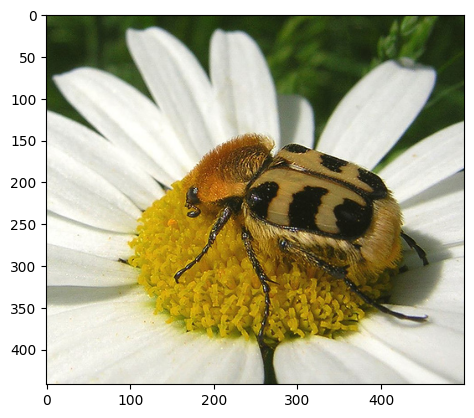

In [20]:
img, label = dataset[120]
plt.imshow(img)

In [21]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

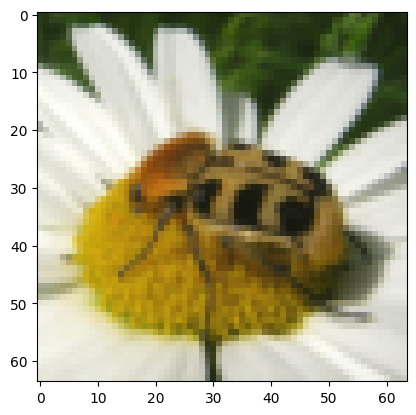

In [22]:
img, label = dataset[120]
plt.imshow(img.permute((1, 2, 0)))

In [23]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3886, 431)

In [25]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])

len(train_ds) , len(valid_ds)

(3886, 431)

In [26]:
from torch.utils.data import DataLoader

batch_size= 132

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle = True,
                      num_workers= 2,
                    pin_memory = True)

valid_dl = DataLoader(valid_ds,
                      batch_size,
                      num_workers= 2,
                    pin_memory = True)

In [27]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow =16).permute(1, 2, 0))
    break

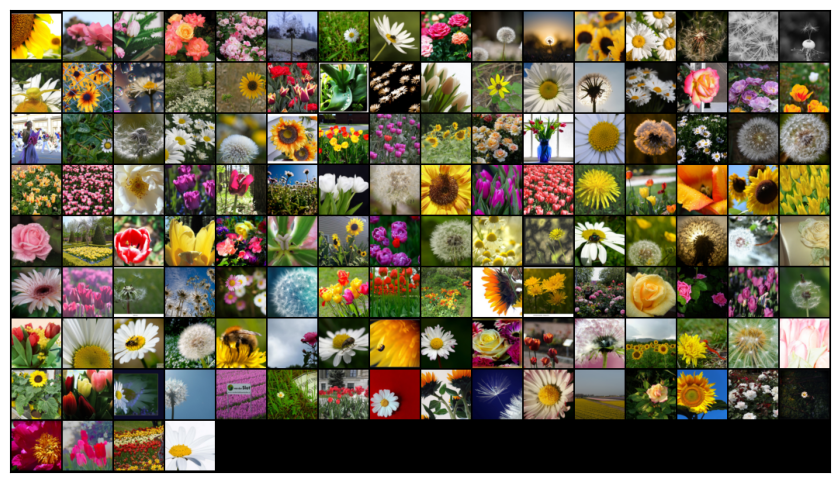

In [28]:
show_batch(train_dl)

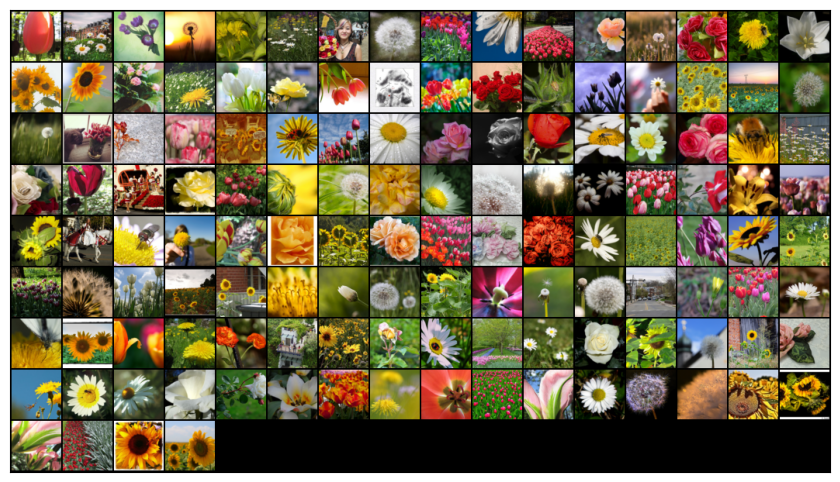

In [29]:
show_batch(valid_dl)

## GPU Utilities

In [30]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [31]:
torch.cuda.is_available()

True

In [32]:
device = get_default_device()
device

device(type='cuda')

In [33]:
img, label = dataset[0]

In [34]:
img.device

device(type='cpu')

In [35]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [36]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model and Training Utilties

In [37]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [38]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model

In [44]:
def conv_block(in_channels, out_channels, pool = False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding= 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]

  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)



class ResNet9(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.conv1 = conv_block(in_channels, 64)
    self.conv2 = conv_block(64, 128, pool=True)
    self.res1 = nn.Sequential(conv_block(128, 128),
                              conv_block(128, 128))

    self.conv3 = conv_block(128, 256, pool=True)
    self.conv4 = conv_block(256, 512, pool=True)
    self.res2 = nn.Sequential(conv_block(512, 512),
                              conv_block(512, 512))

    self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                    nn.Flatten(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, num_classes)
                                    )

  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out =self.classifier(out)
    return(out)


In [45]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [46]:
torch.cuda.empty_cache()
for batch in train_dl:
  images, labels = batch
  print('images.shape', images.shape)
  print('images.device', images.device)
  preds = model(images)
  print('preds.shape' , preds.shape)
  break

images.shape torch.Size([132, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([132, 5])


## Training

In [47]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.6062679290771484, 'val_acc': 0.23327921330928802}]

In [60]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.1960, val_loss: 1.1323, val_acc: 0.5471
Epoch [1], train_loss: 0.9236, val_loss: 1.0098, val_acc: 0.6369
Epoch [2], train_loss: 0.7906, val_loss: 0.9812, val_acc: 0.6468
Epoch [3], train_loss: 0.7259, val_loss: 0.8719, val_acc: 0.6771
Epoch [4], train_loss: 0.6481, val_loss: 0.6830, val_acc: 0.7511


In [61]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.5346, val_loss: 0.6285, val_acc: 0.7814
Epoch [1], train_loss: 0.4865, val_loss: 0.6225, val_acc: 0.7814
Epoch [2], train_loss: 0.4663, val_loss: 0.5803, val_acc: 0.7819
Epoch [3], train_loss: 0.4365, val_loss: 0.5627, val_acc: 0.7966
Epoch [4], train_loss: 0.4207, val_loss: 0.5697, val_acc: 0.7890


In [63]:
history += fit(5, 0.00001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.4013, val_loss: 0.5619, val_acc: 0.7999
Epoch [1], train_loss: 0.3982, val_loss: 0.5531, val_acc: 0.7876
Epoch [2], train_loss: 0.3876, val_loss: 0.5549, val_acc: 0.8004
Epoch [3], train_loss: 0.3853, val_loss: 0.5494, val_acc: 0.8094
Epoch [4], train_loss: 0.3870, val_loss: 0.5481, val_acc: 0.8128


In [64]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.3957, val_loss: 0.5876, val_acc: 0.7819
Epoch [1], train_loss: 0.3810, val_loss: 0.5509, val_acc: 0.8208
Epoch [2], train_loss: 0.3693, val_loss: 0.6567, val_acc: 0.7814
Epoch [3], train_loss: 0.3641, val_loss: 0.5704, val_acc: 0.8113
Epoch [4], train_loss: 0.3399, val_loss: 0.5513, val_acc: 0.8151


In [65]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

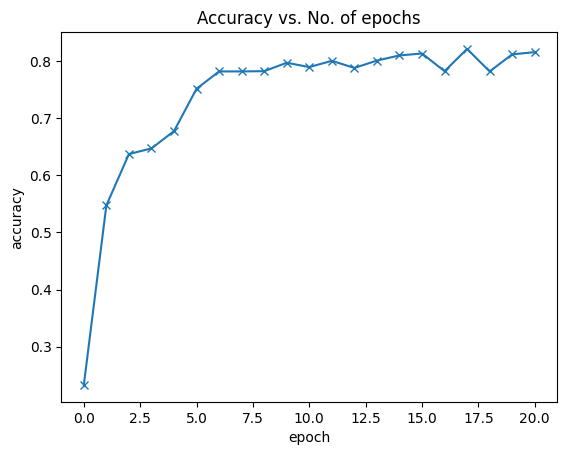

In [66]:
plot_accuracies(history)

In [67]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

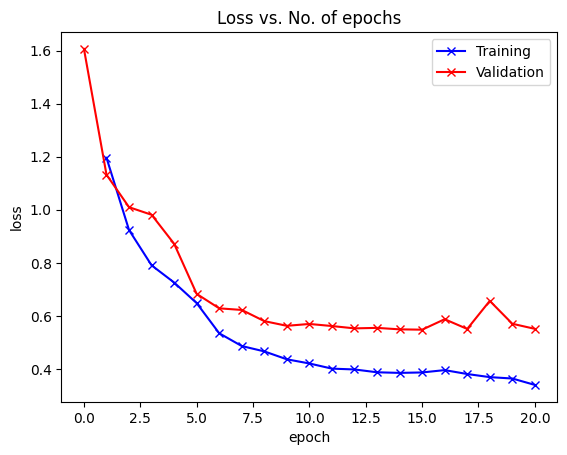

In [68]:
plot_losses(history)

## Results

In [69]:
history[-1]

{'val_loss': 0.5512697696685791,
 'val_acc': 0.8150973320007324,
 'train_loss': 0.33991965651512146}

## Test with Individual Images

In [70]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [71]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Target: tulip
Prediction: tulip


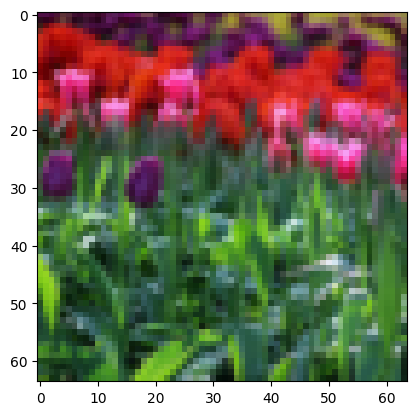

In [79]:
show_image_prediction(*valid_ds[8])

Target: dandelion
Prediction: dandelion


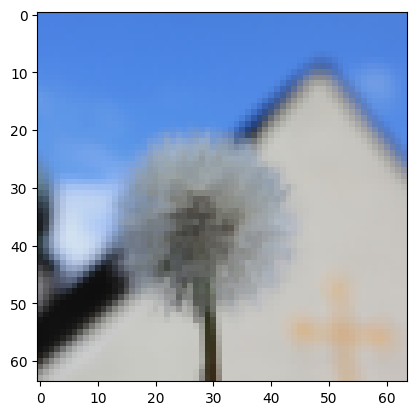

In [73]:
show_image_prediction(*valid_ds[109])

Target: rose
Prediction: rose


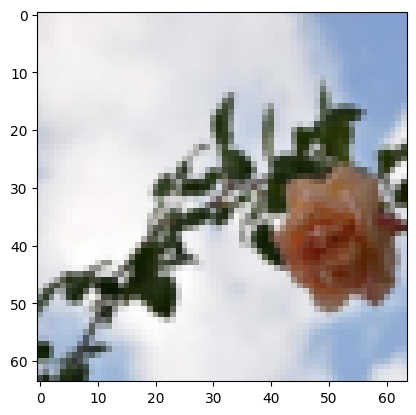

In [74]:
show_image_prediction(*valid_ds[309])

Target: rose
Prediction: rose


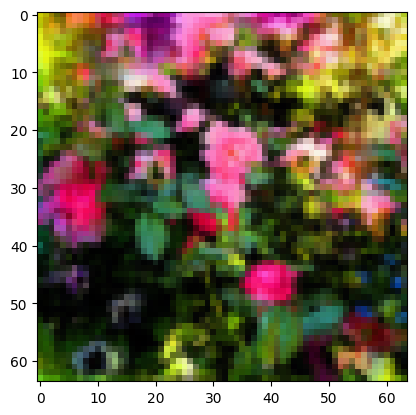

In [76]:
show_image_prediction(*valid_ds[150])